In [1]:

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
init_notebook_mode(connected=True)

import numpy as np
import pandas as pd
import csv

import sklearn
from sklearn.decomposition import TruncatedSVD as TSVD

columns = ['id','task','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataInterviewVisitor.csv',sep=',', names=columns)
frame.head()

,id,task,TaskId,rating
0,0,11010,1,7
1,1,10010,2,7
2,2,11010,3,8
3,3,1000,4,7
4,4,10000,5,6


In [2]:
columns2 =['TaskId','TaskName','Task']
tasks = pd.read_csv('DataRecommenderSystem/TasksInterviewVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','Task']]
task_names.head()

#add
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Interview Task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


#add

In [3]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,task,TaskId,rating,TaskName,Task
0,0,11010,1,7,Task1,11010
1,6,11010,1,9,Task1,11010
2,7,11010,1,7,Task1,11010
3,19,11010,1,10,Task1,11010
4,22,11010,1,4,Task1,11010


In [4]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

#add
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Interview Task',
                   xaxis = dict(title = 'Number of Ratings Per Task'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

#add
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 100))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Interview Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [5]:
rating_crosstab = combined_task_data.pivot_table(values='rating', index='id', columns=['TaskName','Task'], fill_value=0.01)
rating_crosstab

TaskName,Task1,Task10,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
Task,11010,1010,10010,1000,10000,1111110,11110,1110,111010,101110
id,,,,,,,,,,
0,7.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,0.01,0.01,0.01,8.00,0.01,0.01,0.01,0.01,0.01,0.01
3,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01
4,0.01,0.01,0.01,0.01,0.01,6.00,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...
995,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
996,0.01,0.01,0.01,0.01,0.01,0.01,0.01,9.00,0.01,0.01


In [6]:
rating_crosstab.shape
X = rating_crosstab.T
X.shape

(10, 980)

In [7]:
truncated_SVD = TSVD(n_components=10, random_state=0)

resultant_matrix = truncated_SVD.fit_transform(X)

resultant_matrix.shape

(10, 10)

In [8]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape
task_names = rating_crosstab.columns
task_list = list(task_names)
task_list
task = task_list.index(('Task4',10000))
task
corr_1 = corr_mat[task]
corr_1.shape
corr_1

array([-0.10885349, -0.11638919, -0.10879693, -0.11038537,  1.        ,
       -0.11121069, -0.11602953, -0.11123392, -0.1151996 , -0.11676534])

In [9]:
with open('DataRecommenderSystem/recommenderSystemInterview.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list(task_names[(corr_1<=1) & (corr_1 > -0.12)]))



In [10]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)

In [11]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
smt = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
print(smt)
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

{'test_rmse': array([3.01089722, 2.8099509 , 3.32493033, 3.36265459, 3.21295617]),
 'test_mae': array([2.58619658, 2.34222943, 2.93514407, 2.94284178, 2.81262651]),
 'fit_time': (0.00200653076171875,
  0.0020003318786621094,
  0.003000020980834961,
  0.0030007362365722656,
  0.0029997825622558594),
 'test_time': (0.001993417739868164,
  0.0019991397857666016,
  0.0020012855529785156,
  0.00099945068359375,
  0.0010006427764892578)}

In [12]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Estimating biases using als...
RMSE: 2.9607


2.960666844892968

In [13]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

     uid  iid  rui       est                    details  Iu   Ui       err
80   493    6  4.0  4.021562  {'was_impossible': False}   0   27  0.021562
1     30    5  5.0  4.893427  {'was_impossible': False}   0   67  0.106573
66   104    5  5.0  4.893427  {'was_impossible': False}   0   67  0.106573
39   835    7  6.0  5.754976  {'was_impossible': False}   0   89  0.245024
127  578    7  6.0  5.754976  {'was_impossible': False}   0   89  0.245024
29   176    7  6.0  5.754976  {'was_impossible': False}   0   89  0.245024
202  397    7  6.0  5.754976  {'was_impossible': False}   0   89  0.245024
220  810    7  6.0  5.754976  {'was_impossible': False}   0   89  0.245024
200  118    8  5.0  5.272410  {'was_impossible': False}   0   36  0.272410
211  111    2  5.0  5.331941  {'was_impossible': False}   0  131  0.331941
     uid  iid   rui       est                    details  Iu   Ui       err
109   37    5  10.0  4.893427  {'was_impossible': False}   0   67  5.106573
213  533   10  10.0  4.

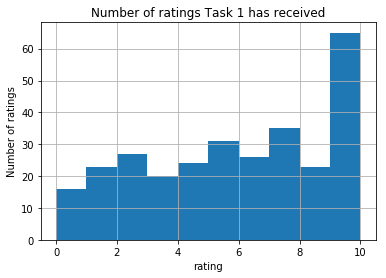

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
#fig = plt.figure()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

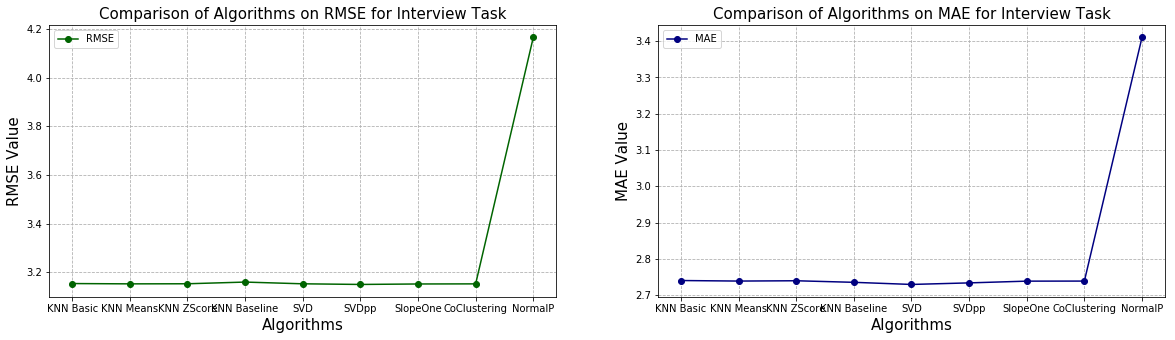

,id,task,TaskId,rating
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,499.500000,5.936050e+04,3.810000,5.228000
std,288.819436,2.161298e+05,2.800311,3.161014
min,0.000000,1.000000e+03,1.000000,0.000000
25%,249.750000,1.001000e+04,1.000000,2.000000
50%,499.500000,1.101000e+04,3.000000,5.000000
75%,749.250000,1.101000e+04,6.000000,8.000000
max,999.000000,1.111110e+06,11.000000,10.000000


In [15]:
# SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, verbose=False)
#nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, verbose=False)
normalPredictor_cv= cross_validate(NormalPredictor(),data, cv=5, verbose=False)
knnBaseline_cv = cross_validate(KNNBaseline(), data, cv=5, verbose=False)

print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 6), '\t', round(knnbasic_cv['test_mae'].mean(), 6))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 6), '\t', round(knnmeans_cv['test_mae'].mean(), 6))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 6), '\t', round(knnz_cv['test_mae'].mean(), 6))
print('KNN Baseline', '\t', round(knnBaseline_cv['test_rmse'].mean(), 6), '\t', round(knnBaseline_cv['test_mae'].mean(), 6))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 6), '\t', round(svd_cv['test_mae'].mean(), 6))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 6), '\t', round(svdpp_cv['test_mae'].mean(), 6))
#print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 6), '\t', round(slope_cv['test_mae'].mean(), 6))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 6), '\t', round(coclus_cv['test_mae'].mean(), 6))
print()
print('NormalPred', '\t', round(normalPredictor_cv['test_rmse'].mean(), 6), '\t', round(normalPredictor_cv['test_mae'].mean(), 6))
print()

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'KNN Baseline', 'SVD', 'SVDpp', 'SlopeOne', 'CoClustering', 'NormalP']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, knnBaseline_cv, svd_cv, svdpp_cv, slope_cv, coclus_cv, normalPredictor_cv]

rmse_cv = [round(res['test_rmse'].mean(), 6) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 6) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE for Interview Task', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE for Interview Task', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()
frame.describe()

In [16]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data)

print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 6), '; MAE:', round(svdpp_gs.best_score['mae'], 6))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 6), '; MAE:', round(svd_gs.best_score['mae'], 6))
#SVDpp best params
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
#SVD best params
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])



SVDpp - RMSE: 3.144988 ; MAE: 2.729261
SVD   - RMSE: 3.148751 ; MAE: 2.728333
RMSE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.6}
MAE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.6}
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

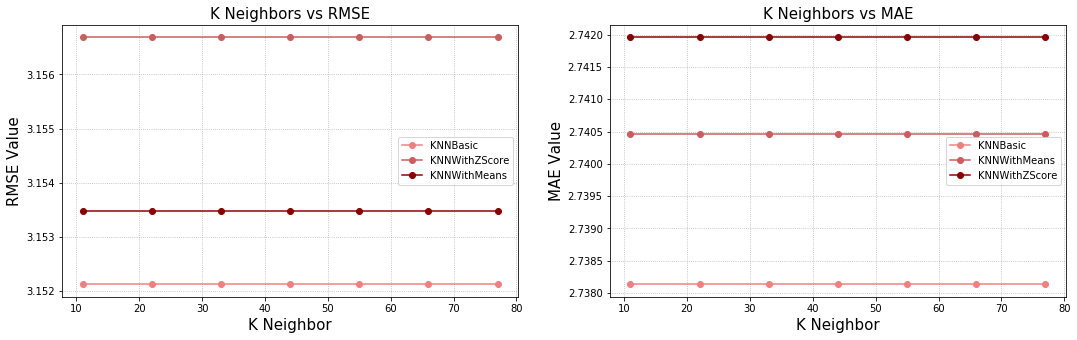

In [17]:
param_grid = {'k': [11, 22, 33, 44, 55, 66, 77]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5)
knnz_gs.fit(data)

x = [11, 22, 33, 44, 55, 66, 77]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')

plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()